In [51]:
import os
import wandb
from gymnasium import spaces
import gymnasium as gym
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common import results_plotter
from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import torch
from stable_baselines3.common.evaluation import evaluate_policy
from imitation.algorithms.density import DensityAlgorithm
from imitation.algorithms import density as db
import pickle
import numpy as np
from sklearn.neighbors import KernelDensity
import joblib
from typing import Any, Dict, Iterable, List, Optional, cast
from imitation.data import types
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import KernelDensity
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.data import rollout
from stable_baselines3.common.base_class import BaseAlgorithm

## Env

In [3]:
class ContinuousFrozenLakeEnv(gym.Env):
    def __init__(self, lake_size=4, hole_radius=0.1, goal_radius=0.1, max_steps=20):
        super(ContinuousFrozenLakeEnv, self).__init__()
        
        # 定义连续状态空间
        self.observation_space = spaces.Box(low=np.array([0.0, 0.0]), 
                                            high=np.array([lake_size, lake_size]), 
                                            dtype=np.float32)
        
        # 定义连续动作空间
        self.action_space = spaces.Box(low=np.array([-1.0, -1.0]), 
                                       high=np.array([1.0, 1.0]), 
                                       dtype=np.float32)
        
        self.lake_size = lake_size
        self.hole_radius = hole_radius
        self.goal_radius = goal_radius
        self.max_steps = max_steps
        self.current_step = 0  # 初始化步数计数器
        
        # 定义洞和目标的位置
        self.holes = np.array([[1.0, 1.0], [2.0, 2.0], [3.0, 1.0], [1.0, 3.0]])
        self.goal = np.array([3.5, 3.5])
        
        self.seed_value = None
        self.reset()

    def reset(self, seed=None, **args):
        if seed is not None:
            self.seed_value = seed
            np.random.seed(self.seed_value)
        
        # 将智能体置于远离洞和目标的随机位置
        while True:
            self.state = np.random.uniform(0, self.lake_size, size=(2,))
            # self.state = np.array([1.0, 3.0])
            if not self._is_in_hole(self.state) and not self._is_in_goal(self.state):
                break
        
        self.current_step = 0  # 重置步数计数器
        return self.state, {}

    def step(self, action):
        self.current_step += 1  # Increment step counter

        # Check if the agent is in a hole
        if self._is_in_hole(self.state):
            # Agent is stuck in the hole but can still take actions within the hole's boundary
            hole_center = self._get_hole_center(self.state)
            potential_next_state = self.state + action
            
            # if distance_to_hole_center <= self.hole_radius:
            if  self._is_in_hole(potential_next_state):
                self.state = potential_next_state
                info = {"result": "1, The agent is now stuck in the hole"}
            else:
                while True:
                    random_tiny_action = np.random.uniform(-0.1, 0.1, size=self.state.shape)
                    tmp_state = self.state + random_tiny_action

                    if self._is_in_hole(tmp_state):
                        self.state = tmp_state
                        break
                info = {"result": "2, The agent is now stuck in the hole"}
            
            # info = {"result": "The agent is now stuck in the hole"}
            if self.current_step >= self.max_steps:
                info = {"result": "failure", "truncated": True}
                return self.state, -0.01, False, True, info #-0.5
            return self.state, -0.01, False, False, info # The episode doesn't end, but the agent is stuck

        else:
            # Update the state based on the action if the agent is not in a hole
            self.state = np.clip(self.state + action, 0.0, self.lake_size)

        # Check if the agent has reached the goal
        if self._is_in_goal(self.state):
            info = {"result": "success"}
            return self.state, 1.0, True, False, info
        
        # Check if the agent has exceeded the maximum number of steps
        if self.current_step >= self.max_steps:
            info = {"result": "failure", "truncated": True}
            return self.state, -0.01, False, True, info #-0.5

        # If neither, return a small negative reward to encourage reaching the goal
        return self.state, -0.01, False, False, {}
    
    def render(self, mode='human'):
        plt.figure(figsize=(6, 6))
        plt.xlim(0, self.lake_size)
        plt.ylim(0, self.lake_size)
        
        # 绘制洞
        for hole in self.holes:
            circle = plt.Circle(hole, self.hole_radius, color='blue', alpha=0.5)
            plt.gca().add_patch(circle)
        
        # 绘制目标
        goal_circle = plt.Circle(self.goal, self.goal_radius, color='green', alpha=0.5)
        plt.gca().add_patch(goal_circle)
        
        # 绘制智能体
        agent_circle = plt.Circle(self.state, 0.05, color='red')
        plt.gca().add_patch(agent_circle)
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid(True)
        plt.show()
    
    def _is_in_hole(self, pos):
        for hole in self.holes:
            if np.linalg.norm(pos - hole) <= self.hole_radius:
                return True
        return False
    
    def _is_in_goal(self, pos):
        return np.linalg.norm(pos - self.goal) <= self.goal_radius

    def _get_hole_center(self, state):
        for hole in self.holes:
            if np.linalg.norm(state - hole) <= self.hole_radius:
                self.hole_center = hole
                return True
        return None


In [3]:
env = ContinuousFrozenLakeEnv(max_steps=20)
env = Monitor(env)
env = DummyVecEnv([lambda: env])

In [8]:
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = TD3('MlpPolicy', env, action_noise=action_noise, verbose=0)
model = TD3.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/FL_TD3_model.zip")

# Reset the environment
state = env.reset()
done = False
terminated = False
truncated =False
while not done:
    action, _states = model.predict(state)
    state, reward, done, info = env.step(action)
    # env.render()  # Visualize the environment
    print(f"Action: {action}, State: {state}, Reward: {reward}, Terminated: {terminated}, Turncated: {truncated}, Info: {info}")

Action: [[ 0.5941403 -0.384853 ]], State: [[1.6289732 2.08871  ]], Reward: [1.], Terminated: False, Turncated: False, Info: [{'result': 'success', 'episode': {'r': 1.0, 'l': 1, 't': 588.207625}, 'TimeLimit.truncated': False, 'terminal_observation': array([3.51729292, 3.55400835])}]


# Trap/Goal Prediction 

## functions

In [11]:
def failed_prob(demos_file, model_file='/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_kde_model.pkl', bandwidth=0.1):
    # 从 .pkl 文件中加载失败示例
    with open(demos_file, 'rb') as f:
        failed_demos = pickle.load(f)

    # 从失败示例中收集所有状态，并计算它们的权重
    states = []
    weights = []

    for demo in failed_demos:
        demo_length = len(demo)
        for i, (state, _, _, _, _, _) in enumerate(demo):
            state = np.squeeze(state)  # 确保状态是 (2,) 形状
            states.append(state)
            weight = (i + 1) / demo_length  # 根据位置计算权重，位置越靠后权重越大
            weights.append(weight)

    states = np.array(states)
    weights = np.array(weights)

    # 训练核密度估计模型
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(states, sample_weight=weights)

    # 保存模型和相关数据
    joblib.dump(kde, model_file)  # 保存KDE模型
    # np.save(states_file, states)  # 保存用于训练的状态
    # np.save(weights_file, weights)  # 保存权重

    return kde

def successful_prob(demos_file, model_file='/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_kde_model.pkl', bandwidth=0.1):
    # 从 .pkl 文件中加载失败示例
    with open(demos_file, 'rb') as f:
        successful_demos = pickle.load(f)

    # 从失败示例中收集所有状态，并计算它们的权重
    states = []
    weights = []

    for demo in successful_demos:
        demo_length = len(demo)
        for i, (state, _, _, _, _, _) in enumerate(demo):
            state = np.squeeze(state)  # 确保状态是 (2,) 形状
            states.append(state)
            weight = (i + 1) / demo_length  # 根据位置计算权重，位置越靠后权重越大
            weights.append(weight)

    states = np.array(states)
    weights = np.array(weights)

    # 训练核密度估计模型
    kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')
    kde.fit(states, sample_weight=weights)

    # 保存模型和相关数据
    joblib.dump(kde, model_file)  # 保存KDE模型

    return kde

def calculate_probability(state_point, kde):
        state_point = np.array(state_point).reshape(1, -1)  # 确保状态点的形状为 (1, 2)
        log_density = kde.score_samples(state_point)  # 计算对数概率密度
        density = np.exp(log_density)  # 转换为实际概率密度
        return density[0]

## test rollout

In [17]:
demos_file = '/files1/Yuxuan_Li/failed_demos/ImitationLearning_demos/FL/failed_demonstrations_200.pkl'
with open(demos_file, 'rb') as f:
    failed_demos = pickle.load(f)

# 从失败示例中收集所有状态，并计算它们的权重
states = []
weights = []

for demo in failed_demos:
    demo_length = len(demo)
    for i, (state, _, _, _, _, _, _) in enumerate(demo):
        state = np.squeeze(state)  # 确保状态是 (2,) 形状
        states.append(state)
        weight = (i + 1) / demo_length  # 根据位置计算权重，位置越靠后权重越大
        weights.append(weight)

## 200 Demos

### KDE train

In [12]:
failed_kde  = failed_prob('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_demonstrations_200.pkl')
successful_kde = successful_prob('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_demonstrations_200.pkl')

### KDE load

In [13]:
failed_kde = joblib.load('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_kde_model.pkl')
successful_kde = joblib.load('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_kde_model.pkl')

In [14]:
state_point = [3.5, 3.5]
failed_prob_density = calculate_probability(state_point, failed_kde)
successful_prob_density = calculate_probability(state_point, successful_kde)
print(f"Failed Prob {state_point}: {failed_prob_density}")
print(f"Successful Prob {state_point}: {successful_prob_density}")

Failed Prob [3.5, 3.5]: 6.17518306214382e-06
Successful Prob [3.5, 3.5]: 0.4602774420714116


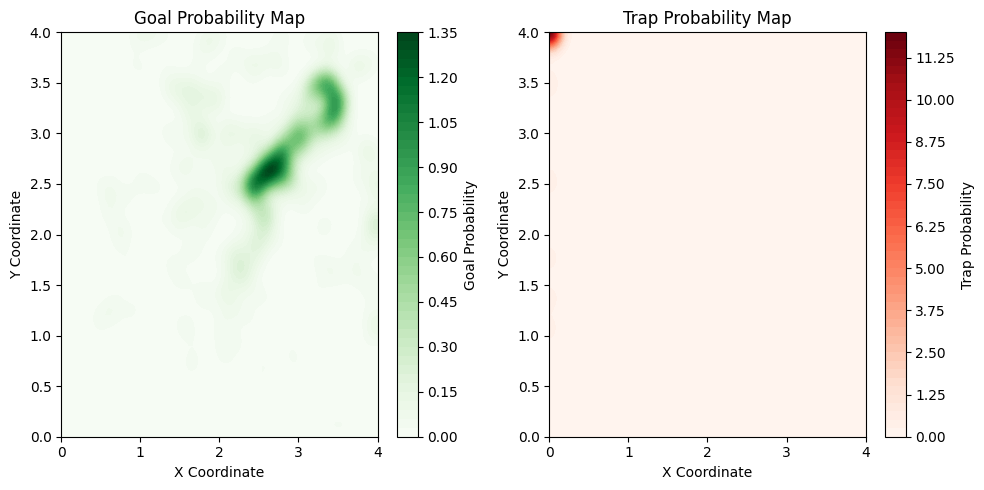

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import KernelDensity

# Load pre-trained KDE models
goal_kde_model_path = '/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_kde_model.pkl'
trap_kde_model_path = '/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_kde_model.pkl'

# Load the KDE models
goal_kde = joblib.load(goal_kde_model_path)
trap_kde = joblib.load(trap_kde_model_path)

# Set up grid world parameters
lake_size = 4
grid_resolution = 100  # Defines how many points to sample along each axis
grid_points = np.linspace(0, lake_size, grid_resolution)

# Create a grid of points covering the entire lake
xv, yv = np.meshgrid(grid_points, grid_points)
grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point

# Calculate the log probability densities for both goal and trap using the KDE models
log_goal_density = goal_kde.score_samples(grid_states)
goal_prob = np.exp(log_goal_density).reshape(grid_resolution, grid_resolution)

log_trap_density = trap_kde.score_samples(grid_states)
trap_prob = np.exp(log_trap_density).reshape(grid_resolution, grid_resolution)

# Visualization of goal and trap probability maps
plt.figure(figsize=(10, 5))

# Plot the goal probability map
plt.subplot(1, 2, 1)
plt.contourf(xv, yv, goal_prob, levels=50, cmap='Greens')
plt.colorbar(label="Goal Probability")
plt.title("Goal Probability Map")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Plot the trap probability map
plt.subplot(1, 2, 2)
plt.contourf(xv, yv, trap_prob, levels=50, cmap='Reds')
plt.colorbar(label="Trap Probability")
plt.title("Trap Probability Map")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

plt.tight_layout()
plt.show()


## 500 Demos

In [16]:
failed_kde  = failed_prob('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_demonstrations_500.pkl')
successful_kde = successful_prob('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_demonstrations_500.pkl')
failed_kde = joblib.load('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_kde_model.pkl')
successful_kde = joblib.load('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_kde_model.pkl')

In [18]:
state_point = [3.5, 3.5]
failed_prob_density = calculate_probability(state_point, failed_kde)
successful_prob_density = calculate_probability(state_point, successful_kde)
print(f"Failed Prob {state_point}: {failed_prob_density}")
print(f"Successful Prob {state_point}: {successful_prob_density}")

Failed Prob [3.5, 3.5]: 0.00010826639930613495
Successful Prob [3.5, 3.5]: 0.37032972735498204


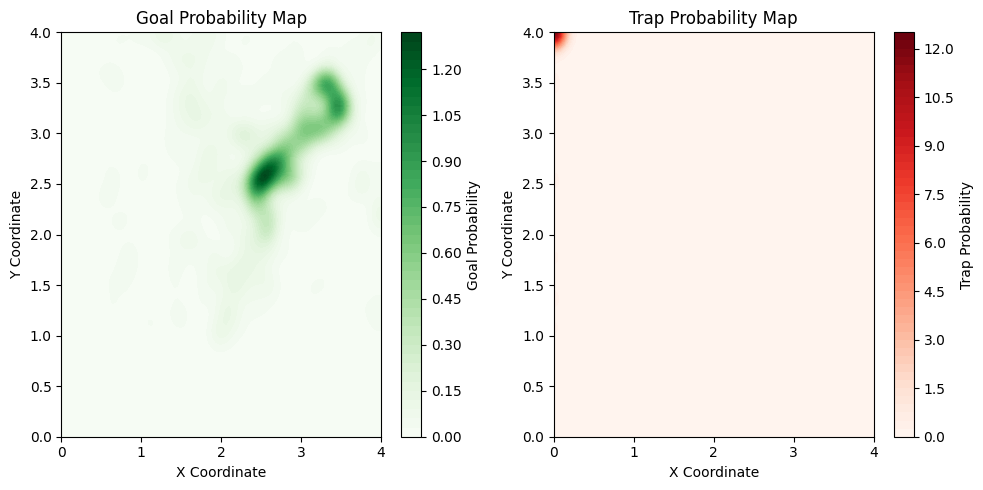

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import KernelDensity

# Load pre-trained KDE models
goal_kde_model_path = '/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_kde_model.pkl'
trap_kde_model_path = '/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_kde_model.pkl'

# Load the KDE models
goal_kde = joblib.load(goal_kde_model_path)
trap_kde = joblib.load(trap_kde_model_path)

# Set up grid world parameters
lake_size = 4
grid_resolution = 100  # Defines how many points to sample along each axis
grid_points = np.linspace(0, lake_size, grid_resolution)

# Create a grid of points covering the entire lake
xv, yv = np.meshgrid(grid_points, grid_points)
grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point

# Calculate the log probability densities for both goal and trap using the KDE models
log_goal_density = goal_kde.score_samples(grid_states)
goal_prob = np.exp(log_goal_density).reshape(grid_resolution, grid_resolution)

log_trap_density = trap_kde.score_samples(grid_states)
trap_prob = np.exp(log_trap_density).reshape(grid_resolution, grid_resolution)

# Visualization of goal and trap probability maps
plt.figure(figsize=(10, 5))

# Plot the goal probability map
plt.subplot(1, 2, 1)
plt.contourf(xv, yv, goal_prob, levels=50, cmap='Greens')
plt.colorbar(label="Goal Probability")
plt.title("Goal Probability Map")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Plot the trap probability map
plt.subplot(1, 2, 2)
plt.contourf(xv, yv, trap_prob, levels=50, cmap='Reds')
plt.colorbar(label="Trap Probability")
plt.title("Trap Probability Map")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

plt.tight_layout()
plt.show()


## 1000 Demos

In [19]:
failed_kde  = failed_prob('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_demonstrations_1000.pkl')
successful_kde = successful_prob('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_demonstrations_1000.pkl')
failed_kde = joblib.load('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_kde_model.pkl')
successful_kde = joblib.load('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_kde_model.pkl')
state_point = [3.5, 3.5]
failed_prob_density = calculate_probability(state_point, failed_kde)
successful_prob_density = calculate_probability(state_point, successful_kde)
print(f"Failed Prob {state_point}: {failed_prob_density}")
print(f"Successful Prob {state_point}: {successful_prob_density}")

Failed Prob [3.5, 3.5]: 8.604169632220999e-05
Successful Prob [3.5, 3.5]: 0.2723433227952211


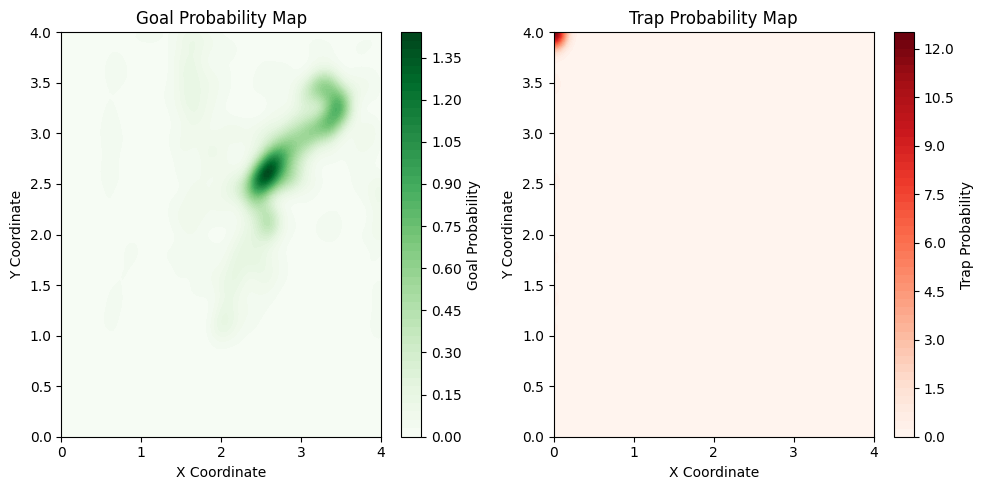

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import KernelDensity

# Load pre-trained KDE models
goal_kde_model_path = '/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_kde_model.pkl'
trap_kde_model_path = '/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_kde_model.pkl'

# Load the KDE models
goal_kde = joblib.load(goal_kde_model_path)
trap_kde = joblib.load(trap_kde_model_path)

# Set up grid world parameters
lake_size = 4
grid_resolution = 100  # Defines how many points to sample along each axis
grid_points = np.linspace(0, lake_size, grid_resolution)

# Create a grid of points covering the entire lake
xv, yv = np.meshgrid(grid_points, grid_points)
grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point

# Calculate the log probability densities for both goal and trap using the KDE models
log_goal_density = goal_kde.score_samples(grid_states)
goal_prob = np.exp(log_goal_density).reshape(grid_resolution, grid_resolution)

log_trap_density = trap_kde.score_samples(grid_states)
trap_prob = np.exp(log_trap_density).reshape(grid_resolution, grid_resolution)

# Visualization of goal and trap probability maps
plt.figure(figsize=(10, 5))

# Plot the goal probability map
plt.subplot(1, 2, 1)
plt.contourf(xv, yv, goal_prob, levels=50, cmap='Greens')
plt.colorbar(label="Goal Probability")
plt.title("Goal Probability Map")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Plot the trap probability map
plt.subplot(1, 2, 2)
plt.contourf(xv, yv, trap_prob, levels=50, cmap='Reds')
plt.colorbar(label="Trap Probability")
plt.title("Trap Probability Map")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

plt.tight_layout()
plt.show()


## 1 Demos

In [23]:
failed_kde  = failed_prob('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_demonstrations_1.pkl')
successful_kde = successful_prob('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_demonstrations_1000.pkl')
failed_kde = joblib.load('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_kde_model.pkl')
successful_kde = joblib.load('/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_kde_model.pkl')
state_point = [3.5, 3.5]
failed_prob_density = calculate_probability(state_point, failed_kde)
successful_prob_density = calculate_probability(state_point, successful_kde)
print(f"Failed Prob {state_point}: {failed_prob_density}")
print(f"Successful Prob {state_point}: {successful_prob_density}")

Failed Prob [3.5, 3.5]: 7.718504509096075e-88
Successful Prob [3.5, 3.5]: 0.2723433227952211


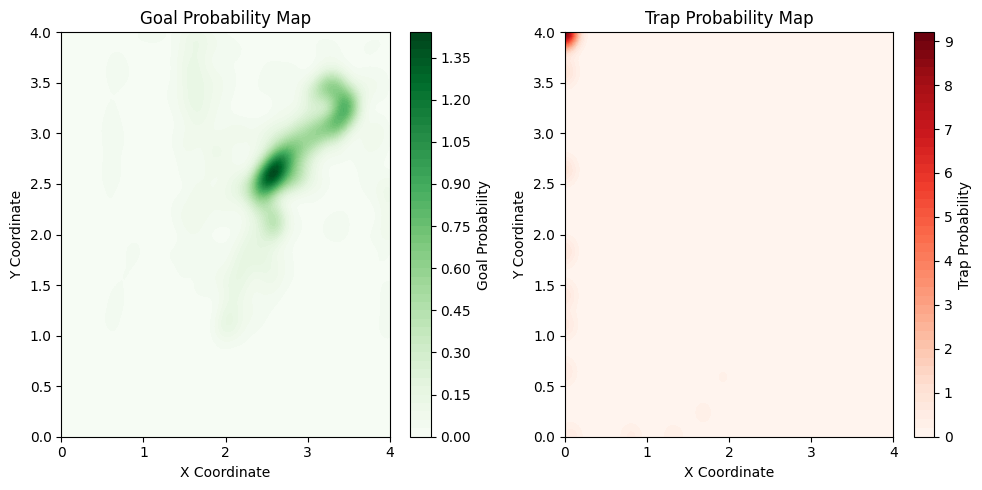

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import KernelDensity

# Load pre-trained KDE models
goal_kde_model_path = '/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/successful_kde_model.pkl'
trap_kde_model_path = '/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_kde_model.pkl'

# Load the KDE models
goal_kde = joblib.load(goal_kde_model_path)
trap_kde = joblib.load(trap_kde_model_path)

# Set up grid world parameters
lake_size = 4
grid_resolution = 100  # Defines how many points to sample along each axis
grid_points = np.linspace(0, lake_size, grid_resolution)

# Create a grid of points covering the entire lake
xv, yv = np.meshgrid(grid_points, grid_points)
grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point

# Calculate the log probability densities for both goal and trap using the KDE models
log_goal_density = goal_kde.score_samples(grid_states)
goal_prob = np.exp(log_goal_density).reshape(grid_resolution, grid_resolution)

log_trap_density = trap_kde.score_samples(grid_states)
trap_prob = np.exp(log_trap_density).reshape(grid_resolution, grid_resolution)

# Visualization of goal and trap probability maps
plt.figure(figsize=(10, 5))

# Plot the goal probability map
plt.subplot(1, 2, 1)
plt.contourf(xv, yv, goal_prob, levels=50, cmap='Greens')
plt.colorbar(label="Goal Probability")
plt.title("Goal Probability Map")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

# Plot the trap probability map
plt.subplot(1, 2, 2)
plt.contourf(xv, yv, trap_prob, levels=50, cmap='Reds')
plt.colorbar(label="Trap Probability")
plt.title("Trap Probability Map")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

plt.tight_layout()
plt.show()


# Test failed Demos last scense

## 直接用pth文件加载demo

In [12]:
env = env = ContinuousFrozenLakeEnv(max_steps=20)

failed_demos_path = '/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/failed_demonstrations_200.pkl'
with open(failed_demos_path, 'rb') as f:
    failed_demos = pickle.load(f)

for demo in failed_demos[20:27]:
    last_state = np.squeeze(demo[-1][0])
    print(demo[-1][0])
    # env.render() 

[[0. 4.]]
[[0. 4.]]
[[0. 4.]]
[[0. 4.]]
[[0. 4.]]
[[0. 4.]]
[[0. 4.]]


In [7]:
demo[-1]

(array([[0., 4.]], dtype=float32),
 array([[-0.9875105,  0.9883487]], dtype=float32),
 array([0.], dtype=float32),
 array([[3.519458 , 1.2535124]], dtype=float32),
 array([ True]),
 array([False]))

In [8]:
demo[-1][0]

array([[0., 4.]], dtype=float32)

## 尝试用rollout函数生产pth文件

### 先测试rollout函数生成了什么

In [54]:
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.data import rollout

env = ContinuousFrozenLakeEnv(max_steps=20)
env = Monitor(env)
env = DummyVecEnv([lambda: env])

rollout_env = DummyVecEnv([lambda: RolloutInfoWrapper(ContinuousFrozenLakeEnv(max_steps=20)) for _ in range(1)])

rng = np.random.default_rng(seed=42) 
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1)
expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/FL_TD3_model.zip")



Using cuda device


In [70]:
rollouts = rollout.rollout(
        expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=5),
        rng=rng,
    )
failed_rollouts = rollout.rollout(
        model,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=5),
        rng=rng,
    )

In [71]:
type(rollouts)
print(len(rollouts))
print(len(failed_rollouts))

36
5


## save rollouts(TrajectoryWithRew) as pkl

In [85]:
import pickle

with open('rollouts.pkl', 'wb') as f:
    pickle.dump(rollouts, f)
with open('failed_rollouts.pkl', 'wb') as f:
    pickle.dump(failed_rollouts, f)

In [84]:
with open('rollouts.pkl', 'rb') as f:
    loaded_rollouts = pickle.load(f)

## explore rollouts(TrajectoryWithRew)

In [77]:
from typing import Any, Dict, Iterable, List, Optional, cast
from imitation.util import util
from imitation.data import types
from imitation.data.types import TrajectoryWithRew
isinstance(failed_rollouts, Iterable)

True

In [78]:
demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)

In [89]:
demonstrations[0].obs[-1]

array([4., 4.])

In [ ]:
for traj in demonstrations:
    # print(traj)
    for i, (obs, act, next_obs) in enumerate(
                        zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
                    ):
                        print(i)

## Visulaize failed_demos last state

In [101]:
env = env = ContinuousFrozenLakeEnv(max_steps=20)

failed_demos_path = 'failed_rollouts.pkl'
with open(failed_demos_path, 'rb') as f:
    failed_rollouts = pickle.load(f) #TrajectoryWithRew

failed_demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
for demo in failed_demonstrations:
    first_state = demo.obs[0]
    last_state = demo.obs[-1]
    print(first_state, last_state)
    # env.render() 

[1.43995787 0.08523602] [4. 4.]
[3.23312243 3.7917551 ] [4. 4.]
[0.83558362 0.90236722] [4. 4.]
[1.56105574 2.94155852] [4. 4.]
[2.81498118 0.06736173] [4. 4.]


# Success Rate of models

In [1]:
def evaluate_agent(env, model, num_episodes=10):
    success_count = 0
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            action, _states = model.predict(state)
            state, reward, done, info = env.step(action)
            if done[0]:
                if info[0].get('result') == 'success':
                    success_count += 1
    success_rate = success_count / num_episodes
    print(f"Success Rate: {success_rate * 100}% over {num_episodes} episodes")

In [6]:
env = ContinuousFrozenLakeEnv(max_steps=50)
env = DummyVecEnv([lambda: env])

n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = TD3('MlpPolicy', env, action_noise=action_noise, verbose=0)
model = TD3.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/assets/FL_TD3_model.zip")

evaluate_agent(env, model)

Success Rate: 100.0% over 10 episodes


In [7]:
evaluate_agent(env, model=TD3.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_Dense_logs/best_model/model_10000.zip"))

Success Rate: 0.0% over 10 episodes


# rollouts to KDE to visualize

In [23]:
def rollout_kde(demos_path, model_file):
    failed_demos_path = demos_path
    model_file = model_file
    with open(failed_demos_path, 'rb') as f:
        failed_rollouts = pickle.load(f) #TrajectoryWithRew
    demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
    states = []
    weights = []

    for traj in demonstrations:
        demo_length = len(traj)
        for i, (obs, act, next_obs) in enumerate(
            zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
        ):
            flat_trans = obs#self._preprocess_transition(obs, act, next_obs)
            weight = (i + 1) / demo_length
            weight = weight * np.exp(weight)
            states.append(flat_trans)
            weights.append(weight)
    states = np.array(states)
    weights = np.array(weights)
    # transitions = {0:np.array(states)}
    transitions = states
    failed_transitions = transitions
    failed_weights = weights
    kde = KernelDensity(bandwidth=0.4, kernel='gaussian')
    kde.fit(failed_transitions, sample_weight=failed_weights)
    # 保存模型和相关数据
    joblib.dump(kde, model_file) 
def calculate_probability(state_point, kde):
        state_point = np.array(state_point).reshape(1, -1)  # 确保状态点的形状为 (1, 2)
        log_density = kde.score_samples(state_point)  # 计算对数概率密度
        density = np.exp(log_density)  # 转换为实际概率密度
        return density[0]

In [21]:
# load rollouts and collect s-weight pair
failed_demos_path = 'failed_rollouts.pkl'
model_file = "rollout_failed_kde_model.pkl"
rollout_kde(failed_demos_path, model_file)
# success kde
success_demos_path = 'rollouts.pkl'
model_file = "rollout_success_kde_model.pkl"
rollout_kde(success_demos_path, model_file)

In [24]:
# kde visualize
failed_kde = joblib.load('rollout_failed_kde_model.pkl')
successful_kde = joblib.load('rollout_success_kde_model.pkl')
state_point = [3.5, 3.5]
failed_prob_density = calculate_probability(state_point, failed_kde)
successful_prob_density = calculate_probability(state_point, successful_kde)
print(f"Failed Prob {state_point}: {failed_prob_density}")
print(f"Successful Prob {state_point}: {successful_prob_density}")

Failed Prob [3.5, 3.5]: 0.20725500370397099
Successful Prob [3.5, 3.5]: 0.21061936552125263


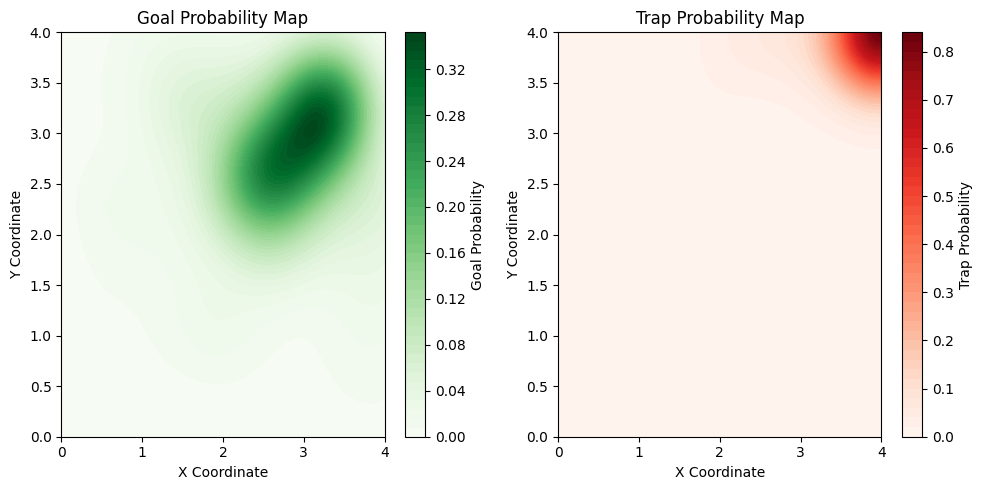

In [25]:
def visualize_kde(goal_kde, trap_kde):
    # Load the KDE models
    goal_kde = goal_kde
    trap_kde = trap_kde
    # Set up grid world parameters
    lake_size = 4
    grid_resolution = 100  # Defines how many points to sample along each axis
    grid_points = np.linspace(0, lake_size, grid_resolution)
    # Create a grid of points covering the entire lake
    xv, yv = np.meshgrid(grid_points, grid_points)
    grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point
    # Calculate the log probability densities for both goal and trap using the KDE models
    log_goal_density = goal_kde.score_samples(grid_states)
    goal_prob = np.exp(log_goal_density).reshape(grid_resolution, grid_resolution)
    log_trap_density = trap_kde.score_samples(grid_states)
    trap_prob = np.exp(log_trap_density).reshape(grid_resolution, grid_resolution)
    # Visualization of goal and trap probability maps
    plt.figure(figsize=(10, 5))
    # Plot the goal probability map
    plt.subplot(1, 2, 1)
    plt.contourf(xv, yv, goal_prob, levels=50, cmap='Greens')
    plt.colorbar(label="Goal Probability")
    plt.title("Goal Probability Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    # Plot the trap probability map
    plt.subplot(1, 2, 2)
    plt.contourf(xv, yv, trap_prob, levels=50, cmap='Reds')
    plt.colorbar(label="Trap Probability")
    plt.title("Trap Probability Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.tight_layout()
    plt.show()

visualize_kde(successful_kde, failed_kde)


# create Randompolicy stablebaselines3 model

In [39]:
from stable_baselines3.common.base_class import BaseAlgorithm

class RandomPolicyModel(BaseAlgorithm):
    def __init__(self, policy, env, verbose=0):
        super(RandomPolicyModel, self).__init__(policy=policy, env=env, verbose=verbose,  learning_rate=0.1)
    
    def _setup_model(self):
        # 这里不设置模型，因为我们不需要模型来生成随机策略
        pass

    def learn(self, total_timesteps, callback=None, log_interval=None, tb_log_name="run", reset_num_timesteps=True):
        # Learn 方法不执行任何操作，因为没有实际的学习过程
        return self

    def predict(self, observation, state=None, episode_start=None, deterministic=False):
        # 随机选择一个动作
        action = self.env.action_space.sample()
        return action, None
    
    def save(self, path):
        # 这个方法通常用于保存模型的状态，但对于随机策略来说不适用
        pass
    
    def load(self, path):
        # 从文件加载模型状态，但随机策略不需要这样做
        return self

# 使用示例
env = ContinuousFrozenLakeEnv(max_steps=20)
env = Monitor(env)
env = DummyVecEnv([lambda: env])
model = RandomPolicyModel(policy=None, env=env)

obs = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    # env.render()
env.close()


In [40]:
env.step(action)

(array([[0.51785254, 3.2801147 ]], dtype=float32),
 array([-0.01], dtype=float32),
 array([ True]),
 [{'result': 'failure',
   'truncated': True,
   'episode': {'r': -0.2, 'l': 20, 't': 2.024585},
   'TimeLimit.truncated': True,
   'terminal_observation': array([0.83697313, 1.81879571])}])

In [41]:
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1)
obs = env.reset()
for _ in range(1000):
    action, _ = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    # env.render()
env.close()

Using cuda device


In [42]:
env.step(action)

(array([[2.9902766, 3.604682 ]], dtype=float32),
 array([-0.01], dtype=float32),
 array([False]),
 [{'TimeLimit.truncated': False}])

# Reward = goal_kde - trap_kde

In [47]:
def visualize_reward(goal_kde, trap_kde):
    # Load the KDE models
    goal_kde = goal_kde
    trap_kde = trap_kde
    # Set up grid world parameters
    lake_size = 4
    grid_resolution = 100  # Defines how many points to sample along each axis
    grid_points = np.linspace(0, lake_size, grid_resolution)
    # Create a grid of points covering the entire lake
    xv, yv = np.meshgrid(grid_points, grid_points)
    grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point
    # Calculate the log probability densities for both goal and trap using the KDE models
    log_goal_density = goal_kde.score_samples(grid_states)
    goal_prob = np.exp(log_goal_density).reshape(grid_resolution, grid_resolution)
    log_trap_density = trap_kde.score_samples(grid_states)
    trap_prob = np.exp(log_trap_density).reshape(grid_resolution, grid_resolution)
    # calculate reward
    reward = goal_prob - trap_prob
    # Visualization of goal and trap probability maps
    plt.figure()
    # Plot the goal probability map
    plt.contourf(xv, yv, reward, levels=50, cmap='Greens')
    plt.colorbar(label="Goal Probability")
    plt.title("Goal Probability Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")


In [48]:
failed_kde = joblib.load('rollout_failed_kde_model.pkl')
successful_kde = joblib.load('rollout_success_kde_model.pkl')

In [ ]:
visualize_reward(successful_kde, failed_kde)

# Try Kernel Regression

In [53]:
class RandomPolicyModel(BaseAlgorithm):
    def __init__(self, policy, env, verbose=0):
        super(RandomPolicyModel, self).__init__(policy=policy, env=env, verbose=verbose,  learning_rate=0.1)
    
    def _setup_model(self):
        # 这里不设置模型，因为我们不需要模型来生成随机策略
        pass

    def learn(self, total_timesteps, callback=None, log_interval=None, tb_log_name="run", reset_num_timesteps=True):
        # Learn 方法不执行任何操作，因为没有实际的学习过程
        return self

    def predict(self, observation, state=None, episode_start=None, deterministic=False):
        # 随机选择一个动作
        action = self.env.action_space.sample()
        return [action], None
    
    def save(self, path):
        # 这个方法通常用于保存模型的状态，但对于随机策略来说不适用
        pass
    
    def load(self, path):
        # 从文件加载模型状态，但随机策略不需要这样做
        return self

In [64]:
# generate rollouts
env = ContinuousFrozenLakeEnv(max_steps=20)
env = Monitor(env)
env = DummyVecEnv([lambda: env])
rollout_env = DummyVecEnv([lambda: RolloutInfoWrapper(ContinuousFrozenLakeEnv(max_steps=20)) for _ in range(1)])

rng = np.random.default_rng(seed=42) 
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1)
expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_50000.zip")
# failed_expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_5000.zip")
failed_expert = RandomPolicyModel(policy=None, env=env)

rollouts = rollout.rollout(
        expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=200),
        rng=rng,
    )
failed_rollouts = rollout.rollout(
        failed_expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=1000),
        rng=rng,
    )
with open('rollouts.pkl', 'wb') as f:
    pickle.dump(rollouts, f)
with open('failed_rollouts.pkl', 'wb') as f:
    pickle.dump(failed_rollouts, f)


Using cuda device


## Train KR

In [65]:
from sklearn.kernel_ridge import KernelRidge
def rollout_kr(demos_path, model_file):
    failed_demos_path = demos_path
    model_file = model_file
    with open(failed_demos_path, 'rb') as f:
        failed_rollouts = pickle.load(f) #TrajectoryWithRew
    demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
    states = []
    weights = []

    for traj in demonstrations:
        demo_length = len(traj)
        for i, (obs, act, next_obs) in enumerate(
            zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
        ):
            flat_trans = obs#self._preprocess_transition(obs, act, next_obs)
            weight = (i + 1) / demo_length
            weight = weight * np.exp(weight)
            states.append(flat_trans)
            weights.append(weight)
    states = np.array(states)
    weights = np.array(weights)
    # transitions = {0:np.array(states)}
    transitions = states
    regression_model = KernelRidge(kernel='rbf', alpha=0.4)
    regression_model.fit(transitions, weights)
    joblib.dump(regression_model, model_file) 

In [66]:
# Train KR
failed_demos_path = 'failed_rollouts.pkl'
model_file = "rollout_failed_kr_model.pkl"
rollout_kr(failed_demos_path, model_file)
# success kde
success_demos_path = 'rollouts.pkl'
model_file = "rollout_success_kr_model.pkl"
rollout_kr(success_demos_path, model_file)

## Visulaize KR model

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_kr(goal_kr, trap_kr):
    # Set up grid world parameters
    lake_size = 4
    grid_resolution = 100  # Defines how many points to sample along each axis
    grid_points = np.linspace(0, lake_size, grid_resolution)
    
    # Create a grid of points covering the entire lake
    xv, yv = np.meshgrid(grid_points, grid_points)
    grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point
    
    # Predict using the kernel regression models for goal and trap
    goal_prob = goal_kr.predict(grid_states).reshape(grid_resolution, grid_resolution)
    trap_prob = trap_kr.predict(grid_states).reshape(grid_resolution, grid_resolution)
    
    # Visualization of goal and trap probability maps
    plt.figure(figsize=(10, 5))
    
    # Plot the goal probability map
    plt.subplot(1, 2, 1)
    plt.contourf(xv, yv, goal_prob, levels=50, cmap='Greens')
    plt.colorbar(label="Goal Probability")
    plt.title("Goal Probability Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    
    # Plot the trap probability map
    plt.subplot(1, 2, 2)
    plt.contourf(xv, yv, trap_prob, levels=50, cmap='Reds')
    plt.colorbar(label="Trap Probability")
    plt.title("Trap Probability Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.tight_layout()
    plt.show()



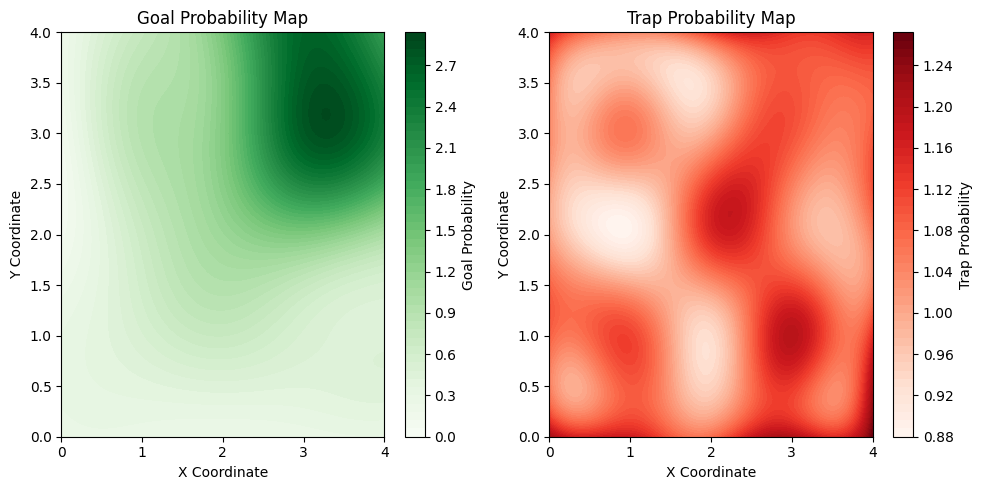

In [68]:
failed_kr = joblib.load('rollout_failed_kr_model.pkl')
successful_kr = joblib.load('rollout_success_kr_model.pkl')
visualize_kr(successful_kr, failed_kr)

## visualize KR reward

In [70]:
def visualize_KR_reward(goal_kr, trap_kr):
    # 这里假设 goal_kr 和 trap_kr 是核回归模型
    # Set up grid world parameters
    lake_size = 4
    grid_resolution = 100  # Defines how many points to sample along each axis
    grid_points = np.linspace(0, lake_size, grid_resolution)
    
    # Create a grid of points covering the entire lake
    xv, yv = np.meshgrid(grid_points, grid_points)
    grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point
    
    # Predict using the kernel regression models for goal and trap
    goal_prob = goal_kr.predict(grid_states).reshape(grid_resolution, grid_resolution)
    trap_prob = trap_kr.predict(grid_states).reshape(grid_resolution, grid_resolution)
    
    # Calculate the reward
    reward = goal_prob - trap_prob
    
    # Visualization of the reward function
    plt.figure(figsize=(8, 6))
    plt.contourf(xv, yv, reward, levels=50, cmap='RdYlGn')
    plt.colorbar(label="Reward")
    plt.title("Reward Function Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

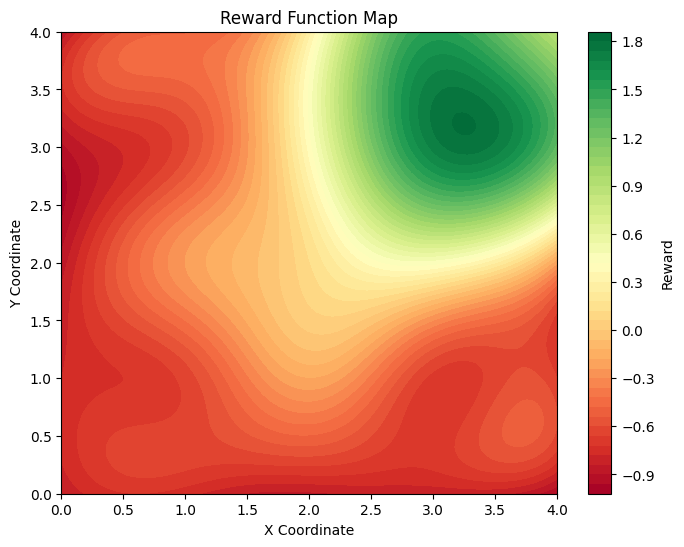

In [71]:
# visualize reward function
failed_kr = joblib.load('rollout_failed_kr_model.pkl')
successful_kr = joblib.load('rollout_success_kr_model.pkl')
visualize_KR_reward(successful_kr, failed_kr)